## ACEPOSE COMPUTER VISION PROJECT MADE BY YASH VAMAN

SOURCE

In [4]:
import kagglehub
dataset_path = kagglehub.dataset_download('orvile/tennis-player-actions-dataset')
print('Dataset import complete.')

100%|██████████| 503M/503M [00:17<00:00, 29.3MB/s]

Extracting files...


Dataset import complete.


DATASET AND DATALOADERS

In [5]:
import os
import torch
import numpy as np
from glob import glob
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

torch.manual_seed(42)

In [6]:
import os
import torch
import numpy as np
from glob import glob
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

torch.manual_seed(42)

class SportsActionDataset(Dataset):
    def __init__(self, root_dir, transform=None, img_paths=None, img_labels=None, img_ext=[".png", ".jpg", ".jpeg"]):
        self.transform = transform
        if img_paths and img_labels:
            self.img_paths = img_paths
            self.img_labels = img_labels
        else:
            self.img_paths = [
                path for ext in img_ext
                for path in glob(f"{root_dir}/*/*{ext}")
                if "assets" not in path
            ]

        self.class_map = {}
        self.class_counts = {}
        counter = 0
        for path in self.img_paths:
            cls_name = self._get_class(path)
            if cls_name not in self.class_map:
                self.class_map[cls_name] = counter
                self.class_counts[cls_name] = 1
                counter += 1
            else:
                self.class_counts[cls_name] += 1

    def _get_class(self, path):
        return os.path.dirname(path).split("/")[-1]

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        path = self.img_paths[idx]
        img = Image.open(path).convert("RGB")
        label = self.img_labels[idx] if self.img_labels else self.class_map[self._get_class(path)]

        if self.transform:
            img = self.transform(img)

        return img, label

    @classmethod
    def create_dataloaders(cls, root_dir, transform, batch_size=16, split=[0.8, 0.1, 0.1], workers=4):
        dataset = cls(root_dir, transform)
        paths = dataset.img_paths
        labels = [dataset.class_map[dataset._get_class(p)] for p in paths]

        # Train/Val/Test split
        train_paths, temp_paths, train_labels, temp_labels = train_test_split(
            paths, labels, test_size=sum(split[1:]), stratify=labels, random_state=42
        )

        val_ratio = split[1] / sum(split[1:])
        val_paths, test_paths, val_labels, test_labels = train_test_split(
            temp_paths, temp_labels, test_size=1-val_ratio, stratify=temp_labels, random_state=42
        )

        train_ds = cls(root_dir, transform, img_paths=train_paths, img_labels=train_labels)
        val_ds = cls(root_dir, transform, img_paths=val_paths, img_labels=val_labels)
        test_ds = cls(root_dir, transform, img_paths=test_paths, img_labels=test_labels)

        # Create dataloaders
        train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=workers)
        val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=workers)
        test_loader = DataLoader(test_ds, batch_size=1, shuffle=False, num_workers=workers)

        return train_loader, val_loader, test_loader, dataset.class_map, [
            train_ds.class_counts,
            val_ds.class_counts,
            test_ds.class_counts
        ]

# Initialize dataloaders
data_root = os.path.join(dataset_path, "Tennis Player Actions Dataset for Human Pose Estimation", "images")
norm_mean = [0.485, 0.456, 0.406]
norm_std = [0.229, 0.224, 0.225]
img_size = 224
batch_size = 32

transform_pipeline = T.Compose([
    T.Resize((img_size, img_size)),
    T.ToTensor(),
    T.Normalize(mean=norm_mean, std=norm_std)
])

train_loader, valid_loader, test_loader, class_dict, count_stats = SportsActionDataset.create_dataloaders(
    root_dir=data_root,
    transform=transform_pipeline,
    batch_size=batch_size
)

print(f"Train batches: {len(train_loader)}")
print(f"Validation batches: {len(valid_loader)}")
print(f"Test samples: {len(test_loader)}")
print(f"Classes: {class_dict}")

Train batches: 50
Validation batches: 7
Test samples: 200
Classes: {'backhand': 0, 'forehand': 1, 'ready_position': 2, 'serve': 3}


DATA ANALYSIS

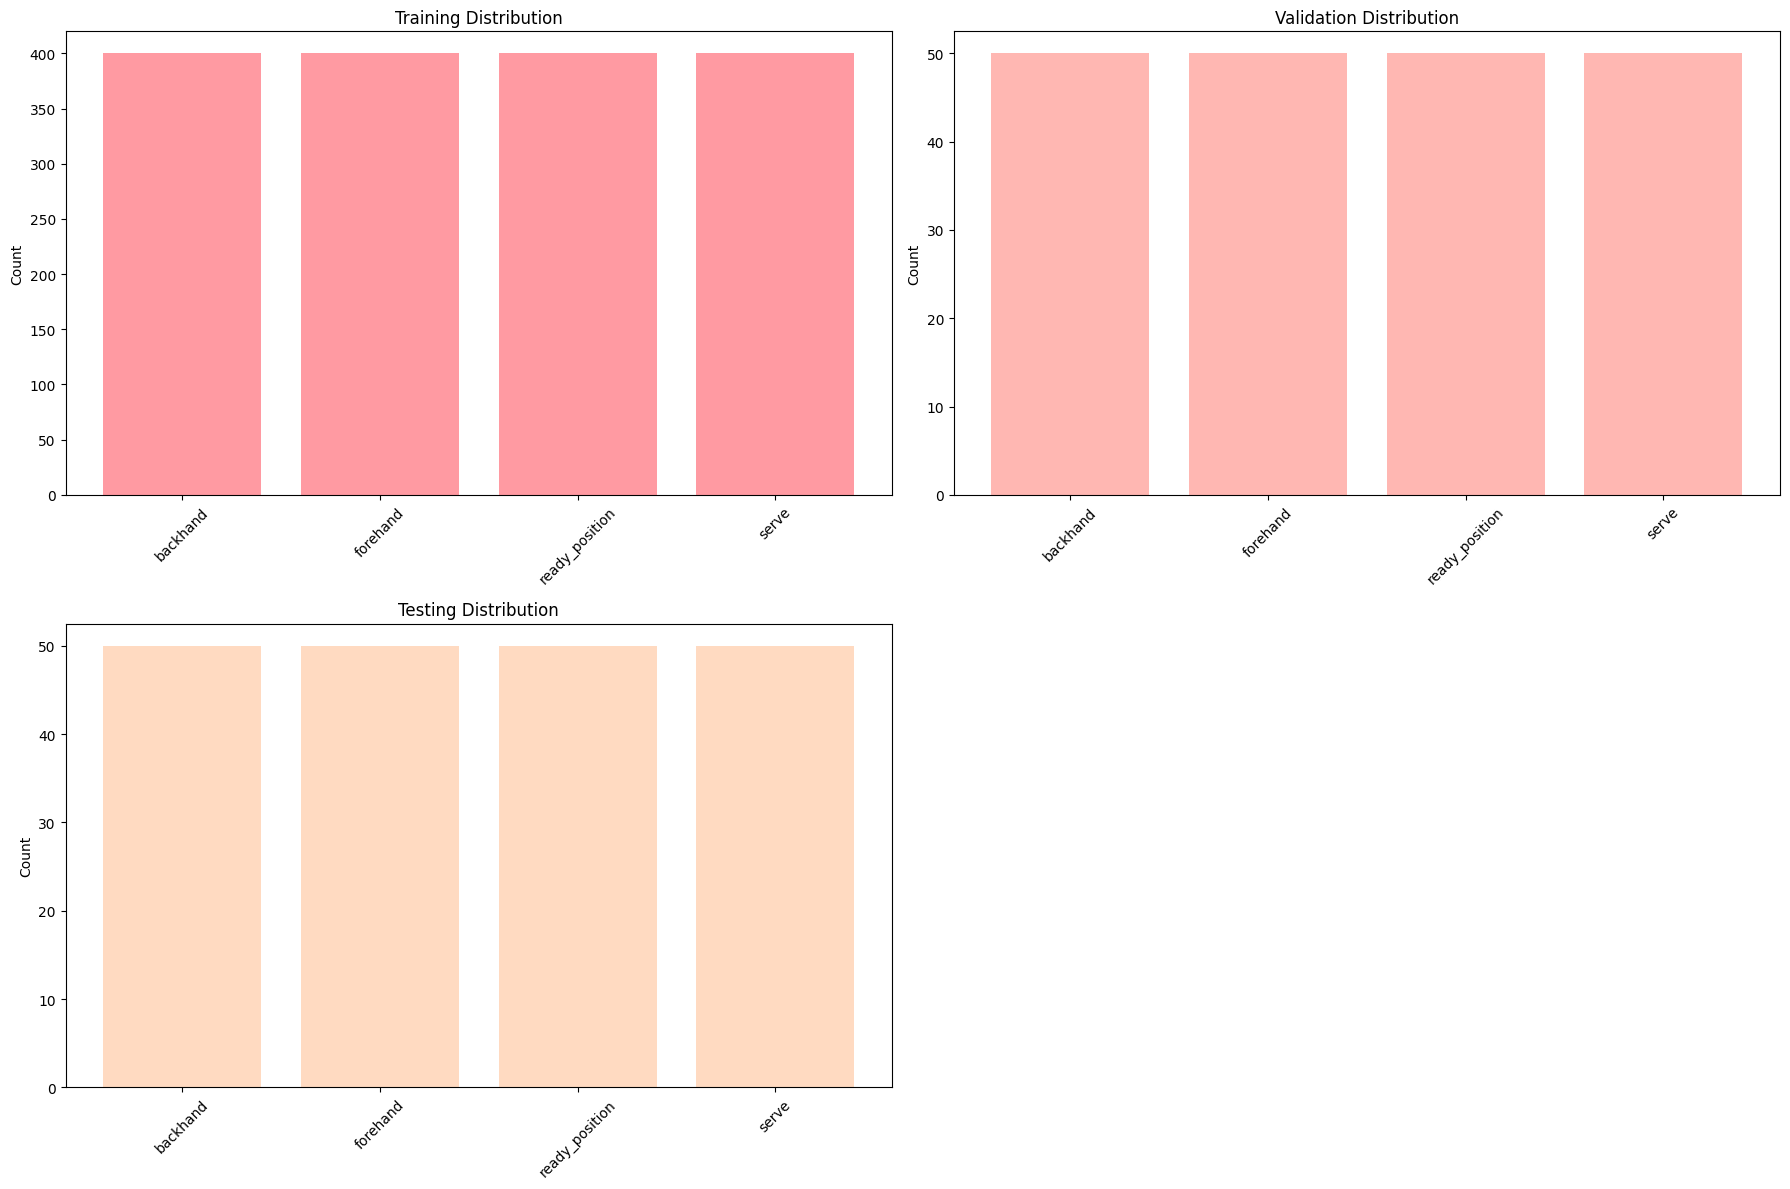

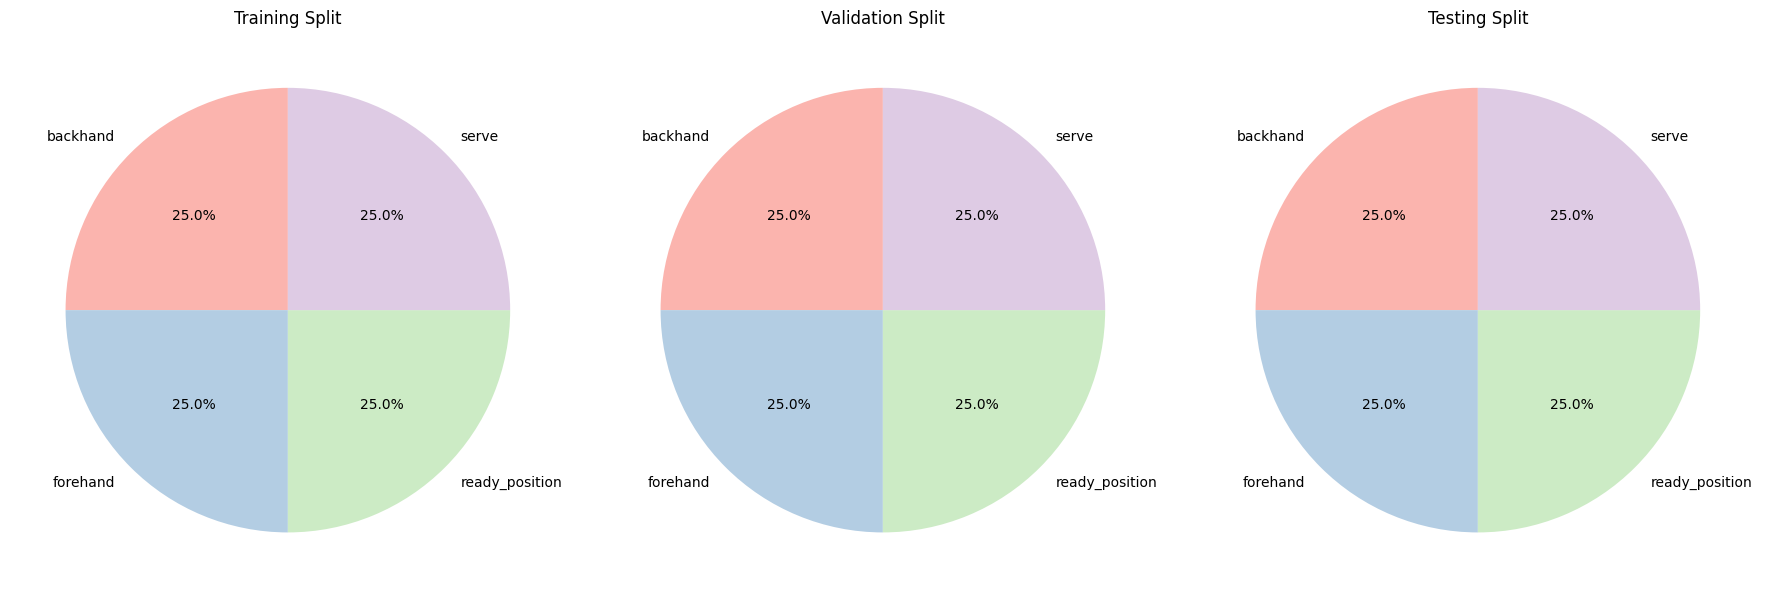

In [7]:
import matplotlib.pyplot as plt

class DataProfiler:
    def __init__(self, class_mapping, count_data, colors=["#FF9AA2", "#FFB7B2", "#FFDAC1"]):
        self.class_names = list(class_mapping.keys())
        self.count_data = count_data
        self.colors = colors
        self.sections = ["Training", "Validation", "Testing"]

    def plot_distribution(self):
        plt.figure(figsize=(18, 12))
        for i, counts in enumerate(self.count_data):
            plt.subplot(2, 2, i+1)
            plt.bar(self.class_names, list(counts.values()), color=self.colors[i])
            plt.title(f"{self.sections[i]} Distribution")
            plt.xticks(rotation=45)
            plt.ylabel("Count")

        plt.tight_layout()
        plt.show()

    def plot_pie_charts(self):
        plt.figure(figsize=(18, 6))
        for i, counts in enumerate(self.count_data):
            plt.subplot(1, 3, i+1)
            plt.pie(
                list(counts.values()),
                labels=self.class_names,
                autopct='%1.1f%%',
                startangle=90,
                colors=plt.cm.Pastel1.colors
            )
            plt.title(f"{self.sections[i]} Split")

        plt.tight_layout()
        plt.show()

profiler = DataProfiler(class_dict, count_stats)
profiler.plot_distribution()
profiler.plot_pie_charts()

DATA VISUALIZATION

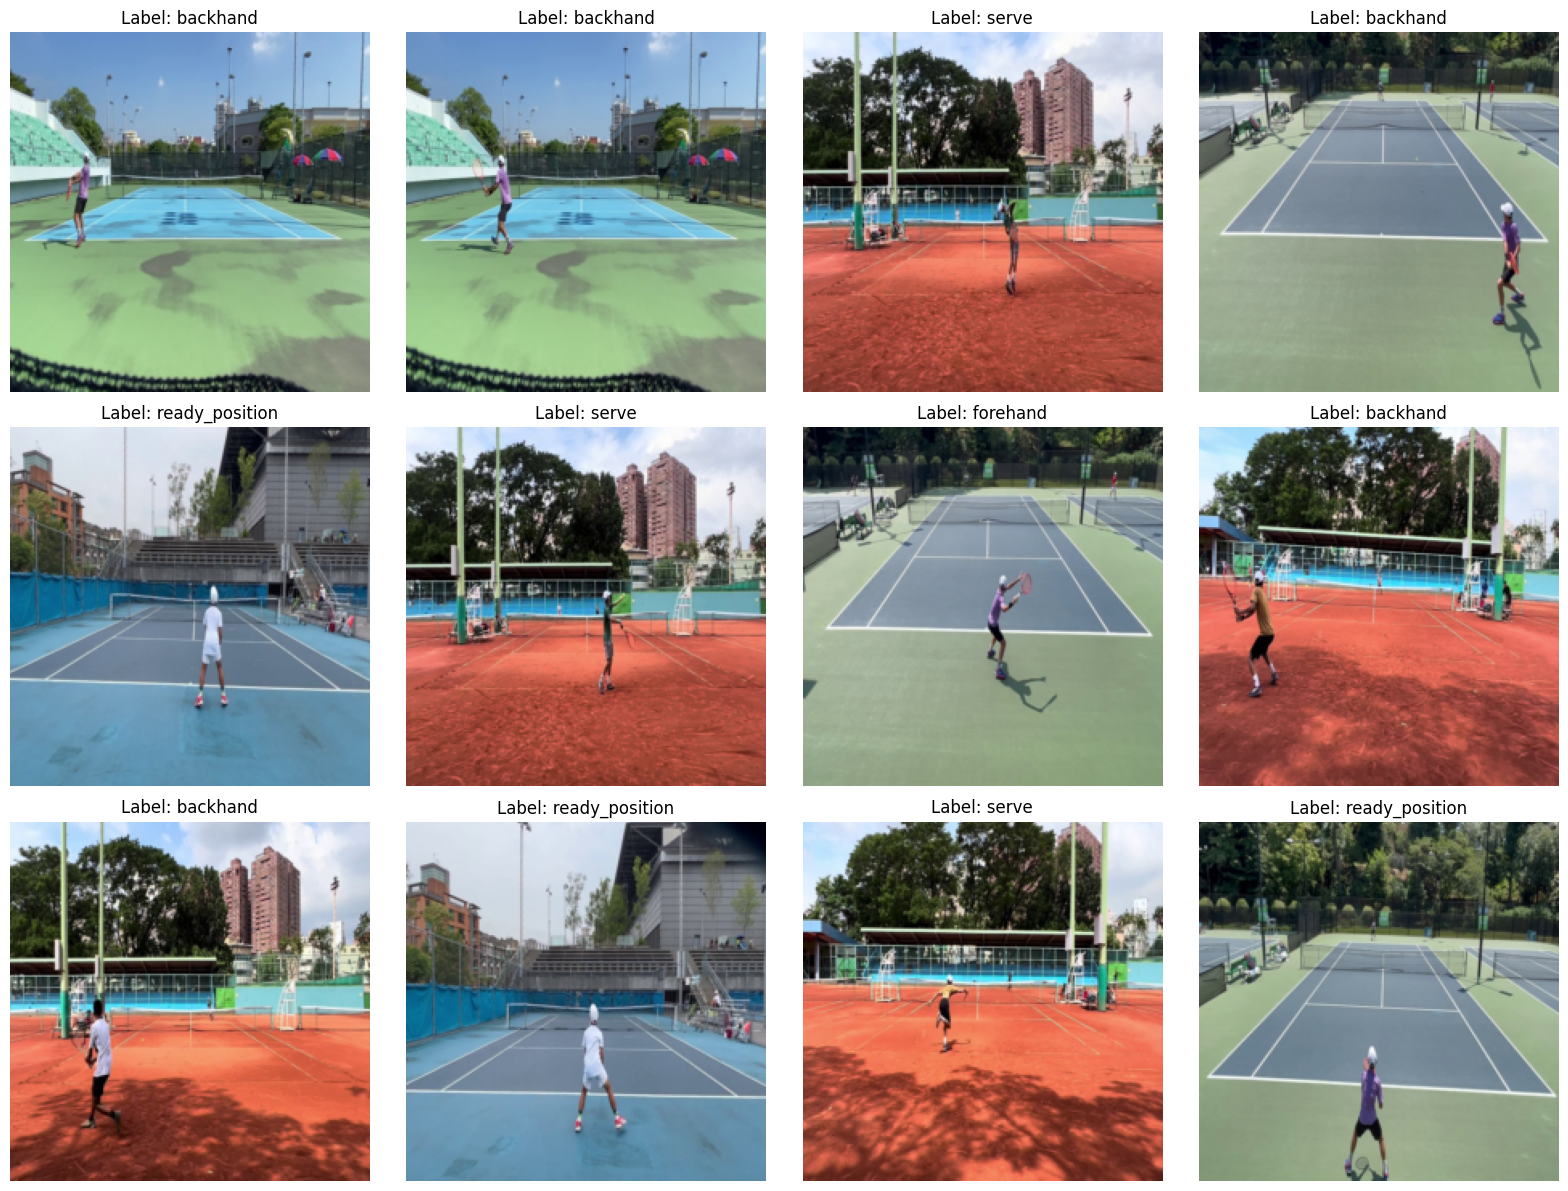

In [8]:
def denormalize(tensor, mean=norm_mean, std=norm_std):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

def show_samples(loader, class_mapping, n_images=12):
    images, labels = next(iter(loader))
    images = images[:n_images]
    labels = labels[:n_images]

    plt.figure(figsize=(16, 12))
    for i in range(n_images):
        plt.subplot(3, 4, i+1)
        img = denormalize(images[i]).permute(1, 2, 0).numpy()
        plt.imshow(np.clip(img, 0, 1))
        plt.title(f"Label: {list(class_mapping.keys())[labels[i]]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

show_samples(train_loader, class_dict)

MODEL TRAINING

In [9]:
import timm
!pip install torchmetrics
import torchmetrics
from tqdm import tqdm
import torch # Added import torch here

class ActionTrainer:
    def __init__(self, model_name, num_classes, train_loader, valid_loader, device, lr=0.001, epochs=30, patience=5):
        self.model = timm.create_model(model_name, pretrained=True, num_classes=num_classes).to(device)
        self.train_loader = train_loader
        self.valid_loader = valid_loader
        self.device = device
        self.epochs = epochs
        self.patience = patience

        self.criterion = torch.nn.CrossEntropyLoss()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)
        self.f1_metric = torchmetrics.F1Score(task="multiclass", num_classes=num_classes).to(device)

        self.train_losses = []
        self.valid_losses = []
        self.train_f1s = []
        self.valid_f1s = []
        self.best_f1 = 0.0

    def train_epoch(self):
        self.model.train()
        epoch_loss = 0.0
        self.f1_metric.reset()

        for images, labels in tqdm(self.train_loader, desc="Training"):
            images, labels = images.to(self.device), labels.to(self.device)

            self.optimizer.zero_grad()
            outputs = self.model(images)
            loss = self.criterion(outputs, labels)
            loss.backward()
            self.optimizer.step()

            epoch_loss += loss.item() * images.size(0)
            self.f1_metric.update(outputs, labels)

        epoch_loss /= len(self.train_loader.dataset)
        epoch_f1 = self.f1_metric.compute()
        return epoch_loss, epoch_f1

    def validate_epoch(self):
        self.model.eval()
        epoch_loss = 0.0
        self.f1_metric.reset()

        with torch.no_grad():
            for images, labels in tqdm(self.valid_loader, desc="Validation"):
                images, labels = images.to(self.device), labels.to(self.device)
                outputs = self.model(images)
                loss = self.criterion(outputs, labels)

                epoch_loss += loss.item() * images.size(0)
                self.f1_metric.update(outputs, labels)

        epoch_loss /= len(self.valid_loader.dataset)
        epoch_f1 = self.f1_metric.compute()
        return epoch_loss, epoch_f1

    def run(self):
        for epoch in range(self.epochs):
            print(f"\nEpoch {epoch+1}/{self.epochs}")

            train_loss, train_f1 = self.train_epoch()
            valid_loss, valid_f1 = self.validate_epoch()

            self.train_losses.append(train_loss)
            self.valid_losses.append(valid_loss)
            self.train_f1s.append(train_f1.item())
            self.valid_f1s.append(valid_f1.item())

            print(f"Train Loss: {train_loss:.4f} | Val Loss: {valid_loss:.4f}")
            print(f"Train F1: {train_f1:.4f} | Val F1: {valid_f1:.4f}")

            # Save best model
            if valid_f1 > self.best_f1:
                self.best_f1 = valid_f1
                torch.save(self.model.state_dict(), "best_model.pth")
                print(f"Saved new best model with F1: {valid_f1:.4f}")
                no_improve = 0
            else:
                no_improve += 1
                if no_improve >= self.patience:
                    print("Early stopping triggered")
                    break

device = "cuda" if torch.cuda.is_available() else "cpu"
trainer = ActionTrainer(
    model_name="rexnet_150",
    num_classes=len(class_dict),
    train_loader=train_loader,
    valid_loader=valid_loader,
    device=device,
    lr=0.0003,
    epochs=25,
    patience=3
)
trainer.run()

model.safetensors:   0%|          | 0.00/39.2M [00:00<?, ?B/s]


Epoch 1/25


Validation: 100%|██████████| 7/7 [00:19<00:00,  2.74s/it]


Train Loss: 1.0240 | Val Loss: 0.4389
Train F1: 0.7281 | Val F1: 0.8750
Saved new best model with F1: 0.8750

Epoch 2/25


Validation: 100%|██████████| 7/7 [00:18<00:00,  2.69s/it]


Train Loss: 0.1630 | Val Loss: 0.0771
Train F1: 0.9456 | Val F1: 0.9700
Saved new best model with F1: 0.9700

Epoch 3/25


Validation: 100%|██████████| 7/7 [00:17<00:00,  2.53s/it]


Train Loss: 0.0444 | Val Loss: 0.1455
Train F1: 0.9850 | Val F1: 0.9550

Epoch 4/25


Validation: 100%|██████████| 7/7 [00:18<00:00,  2.65s/it]


Train Loss: 0.0689 | Val Loss: 0.2611
Train F1: 0.9775 | Val F1: 0.9350

Epoch 5/25


Validation: 100%|██████████| 7/7 [00:18<00:00,  2.58s/it]

Train Loss: 0.0388 | Val Loss: 0.1888
Train F1: 0.9850 | Val F1: 0.9500
Early stopping triggered


LEARNING CURVES

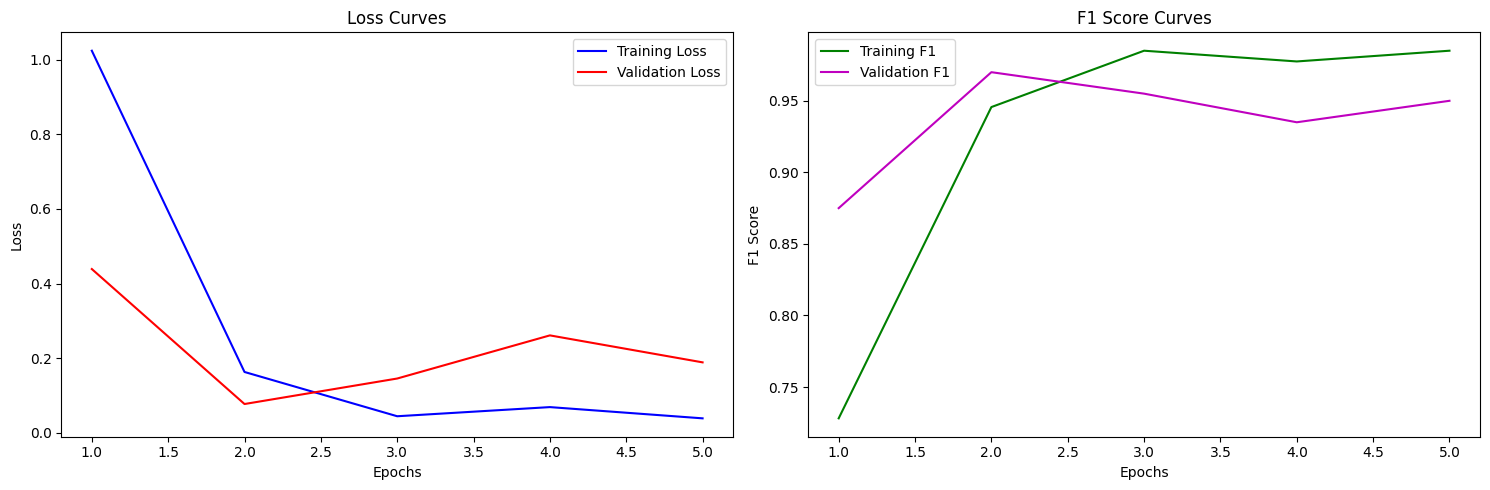

In [10]:
def plot_metrics(train_loss, valid_loss, train_f1, valid_f1):
    epochs = range(1, len(train_loss)+1)

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, 'b-', label='Training Loss')
    plt.plot(epochs, valid_loss, 'r-', label='Validation Loss')
    plt.title('Loss Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_f1, 'g-', label='Training F1')
    plt.plot(epochs, valid_f1, 'm-', label='Validation F1')
    plt.title('F1 Score Curves')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_metrics(trainer.train_losses, trainer.valid_losses, trainer.train_f1s, trainer.valid_f1s)

INFERENCE & GRADCAM

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 53.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.5-py3-none-any.whl size=44284 sha256=f320d3c4356b8ca5f8b62691685dc7592c896b4d8b73719a4f6063470e864c1e
  Stored in directory: /root/.cache/pip/wheels/bc/52/78/893c3b94279ef238f43a9e89608af648de401b96415bebbd1f
Successfully built grad-cam


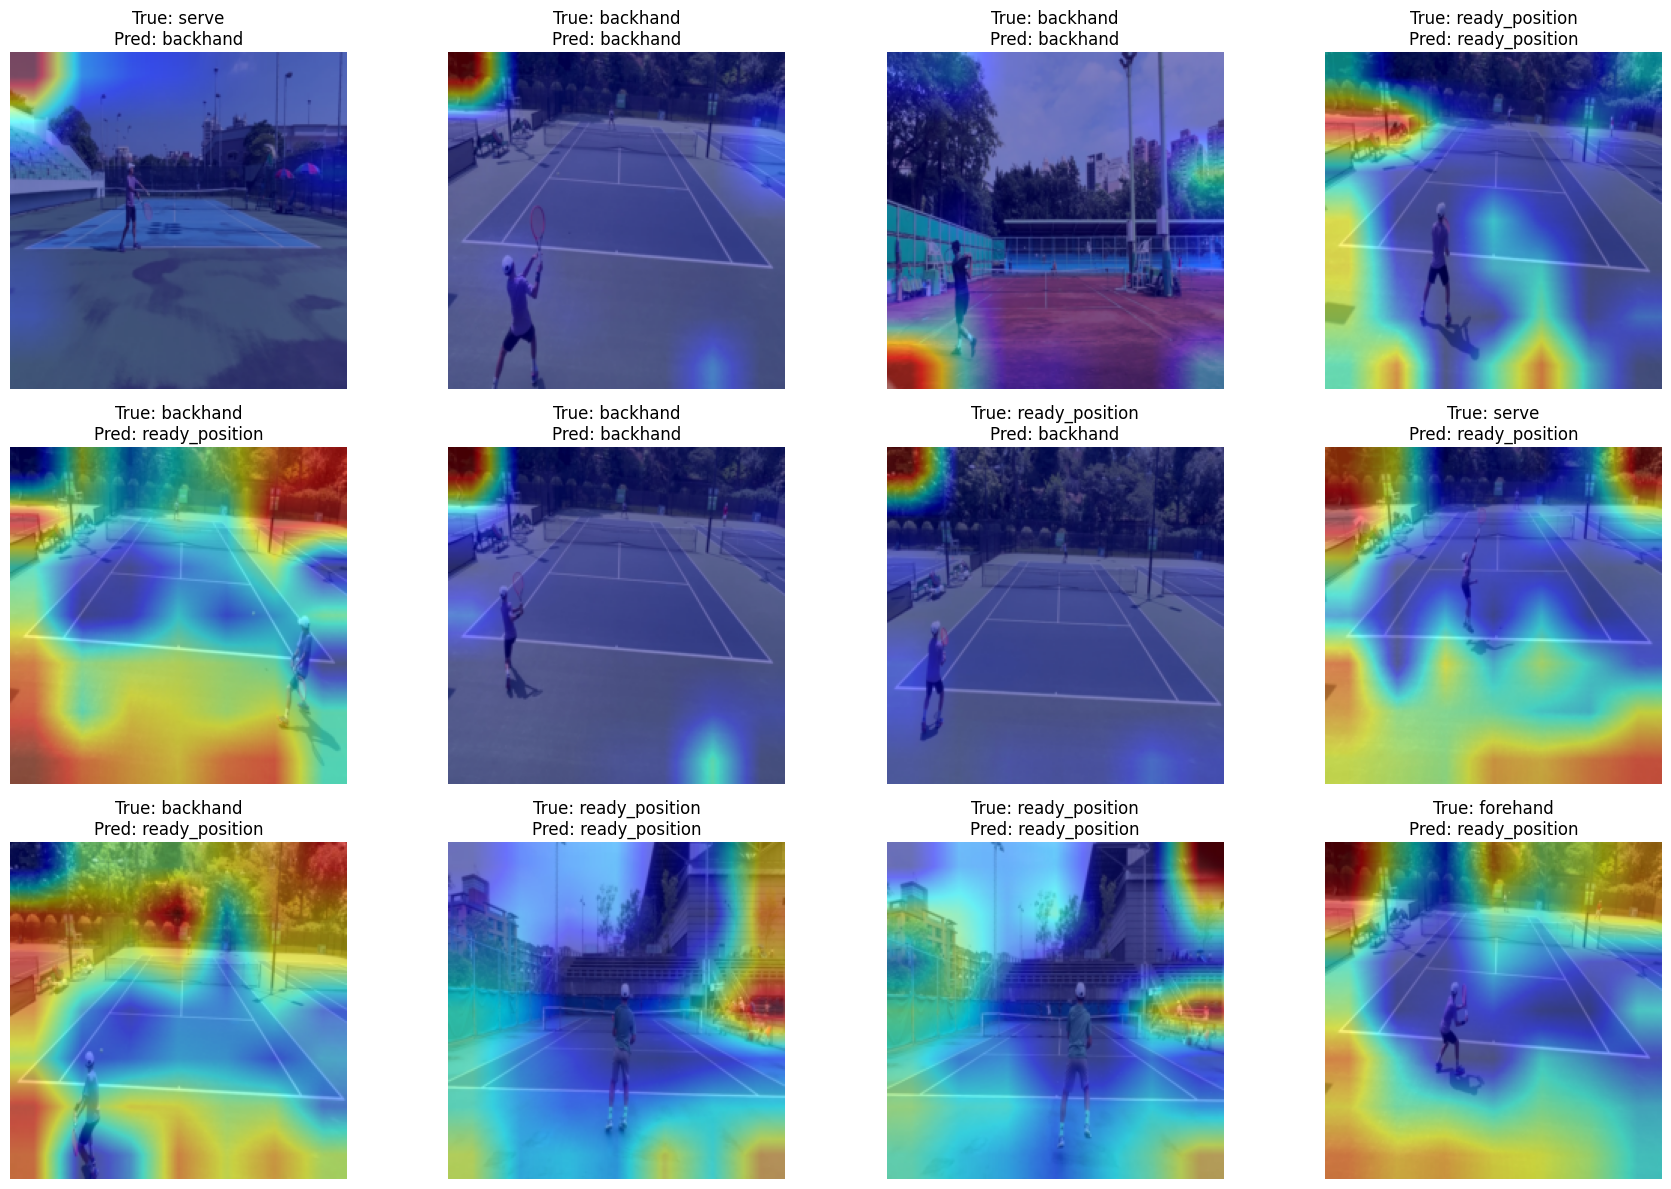

In [11]:
!pip install grad-cam
import cv2
import numpy as np
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

class ActionRecognizer:
    def __init__(self, model, class_mapping, device):
        self.model = model
        self.class_mapping = {v: k for k, v in class_mapping.items()}
        self.device = device
        self.model.eval()

    def predict(self, image_tensor):
        with torch.no_grad():
            output = self.model(image_tensor.unsqueeze(0).to(self.device))
            probs = torch.nn.functional.softmax(output, dim=1)
            pred_class = torch.argmax(probs, dim=1).item()
        return self.class_mapping[pred_class], probs[0].cpu().numpy()

    def generate_cam(self, image_tensor):
        target_layers = [self.model.features[-1].conv]
        cam = GradCAM(model=self.model, target_layers=target_layers)
        grayscale_cam = cam(input_tensor=image_tensor.unsqueeze(0).to(self.device))[0, :]
        return grayscale_cam

def visualize_results(loader, recognizer, n_samples=12):
    plt.figure(figsize=(18, 12))
    samples = 0

    for images, true_labels in loader:
        images = images.to(device)
        for img, true_label in zip(images, true_labels):
            # Prepare image
            img_np = denormalize(img.cpu()).permute(1, 2, 0).numpy()
            img_np = np.clip(img_np, 0, 1)

            # Get prediction
            pred_class, probs = recognizer.predict(img)
            true_class = recognizer.class_mapping[true_label.item()]

            # Generate CAM
            cam = recognizer.generate_cam(img)
            visualization = show_cam_on_image(img_np, cam, use_rgb=True)

            # Plot results
            plt.subplot(3, 4, samples+1)
            plt.imshow(visualization)
            plt.title(f"True: {true_class}\nPred: {pred_class}")
            plt.axis('off')

            samples += 1
            if samples >= n_samples:
                plt.tight_layout()
                plt.show()
                return

# Initialize recognizer
model = timm.create_model("rexnet_150", num_classes=len(class_dict)).to(device)
model.load_state_dict(torch.load("best_model.pth"))
recognizer = ActionRecognizer(model, class_dict, device)

visualize_results(test_loader, recognizer)